In [1]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
import shutil

In [3]:
# Directories
src_dir = "/Users/ouzibigouziouzi/Desktop/FNNPK/train_data"
dst_dir = "/Users/ouzibigouziouzi/Desktop/FNNPK/test_data"

# Make sure destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Proportion of images to use for testing
test_ratio = 0.2

# Seed for reproducibility
np.random.seed(42)

# Counter for tracking moved images
total_moved_images = 0

# For each class directory in the source directory
for class_dir in os.listdir(src_dir):
    if os.path.isdir(os.path.join(src_dir, class_dir)):
        # List all image files in this class directory
        images = os.listdir(os.path.join(src_dir, class_dir))
        
        # Determine the number of images to move
        n_test_images = int(len(images) * test_ratio)
        
        # Select the first n_test_images from each class
        test_images = images[:n_test_images]
        
        # Create a new directory for this class in the destination directory
        os.makedirs(os.path.join(dst_dir, class_dir), exist_ok=True)
        
        # Move the test images to the destination directory if the destination directory is empty
        if len(os.listdir(os.path.join(dst_dir, class_dir))) == 0:
            for image in test_images:
                shutil.move(os.path.join(src_dir, class_dir, image), os.path.join(dst_dir, class_dir, image))
                total_moved_images += 1

# Print the number of images moved
if total_moved_images > 0:
    print(f"Moved {total_moved_images} images from {src_dir} to {dst_dir}.")
else:
    print("No images were moved because the destination directory is not empty.")


No images were moved because the destination directory is not empty.


In [4]:
# Define the directory path containing the images
data_directory = "/Users/ouzibigouziouzi/Desktop/FNNPK/train_data"
batch_size = 7
image_size = (50,50)
epoch_size = 250
fold_size = 3

In [5]:
# Create the KFold object
kfold = KFold(n_splits=fold_size, shuffle=True, random_state=42)

In [6]:
# Initialize lists to store the fold results
fold_train_loss = []
fold_train_accuracy = []
fold_val_loss = []
fold_val_accuracy = []

In [7]:
# Perform k-fold cross-validation
fold = 1
for train_index, val_index in kfold.split(os.listdir(data_directory)):
    print(f"Fold {fold}:")

    # Load and preprocess the data for training set
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_directory,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="training"
    )

    # Load and preprocess the data for validation set
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_directory,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="validation"
    )

    # Define data augmentation
    data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.Resizing(image_size[0], image_size[1]),
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.3), 
      #preprocessing.RandomZoom(0.1)
    ])

    # Define the model architecture
    model = Sequential([
        data_augmentation,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_data, validation_data=val_data, epochs=epoch_size)

    # Store the fold results
    fold_train_loss.append(history.history['loss'])
    fold_train_accuracy.append(history.history['accuracy'])
    fold_val_loss.append(history.history['val_loss'])
    fold_val_accuracy.append(history.history['val_accuracy'])

    fold += 1

Fold 1:
Found 229 files belonging to 4 classes.


Using 184 files for training.
Found 229 files belonging to 4 classes.
Using 45 files for validation.
Epoch 1/250
27/27 [==============================] - 2s 39ms/step - loss: 1.4046 - accuracy: 0.2391 - val_loss: 1.3700 - val_accuracy: 0.2667
Epoch 2/250
27/27 [==============================] - 2s 52ms/step - loss: 1.3078 - accuracy: 0.3696 - val_loss: 1.1987 - val_accuracy: 0.4889
Epoch 3/250
27/27 [==============================] - 2s 45ms/step - loss: 1.1512 - accuracy: 0.5000 - val_loss: 1.3061 - val_accuracy: 0.4000
Epoch 4/250
27/27 [==============================] - 1s 39ms/step - loss: 1.1179 - accuracy: 0.4674 - val_loss: 0.9280 - val_accuracy: 0.6000
Epoch 5/250
27/27 [==============================] - 1s 37ms/step - loss: 0.9136 - accuracy: 0.6087 - val_loss: 1.0802 - val_accuracy: 0.4444
Epoch 6/250
27/27 [==============================] - 1s 35ms/step - loss: 0.8962 - accuracy: 0.6033 - val_loss: 0.9406 - val_accuracy: 0.6667
Epoch 7/250
27/27 [============================

7/7 [==============================] - 0s 6ms/step - loss: 0.7543 - accuracy: 0.8000
Validation Loss: 0.7543210983276367
Validation Accuracy: 0.800000011920929


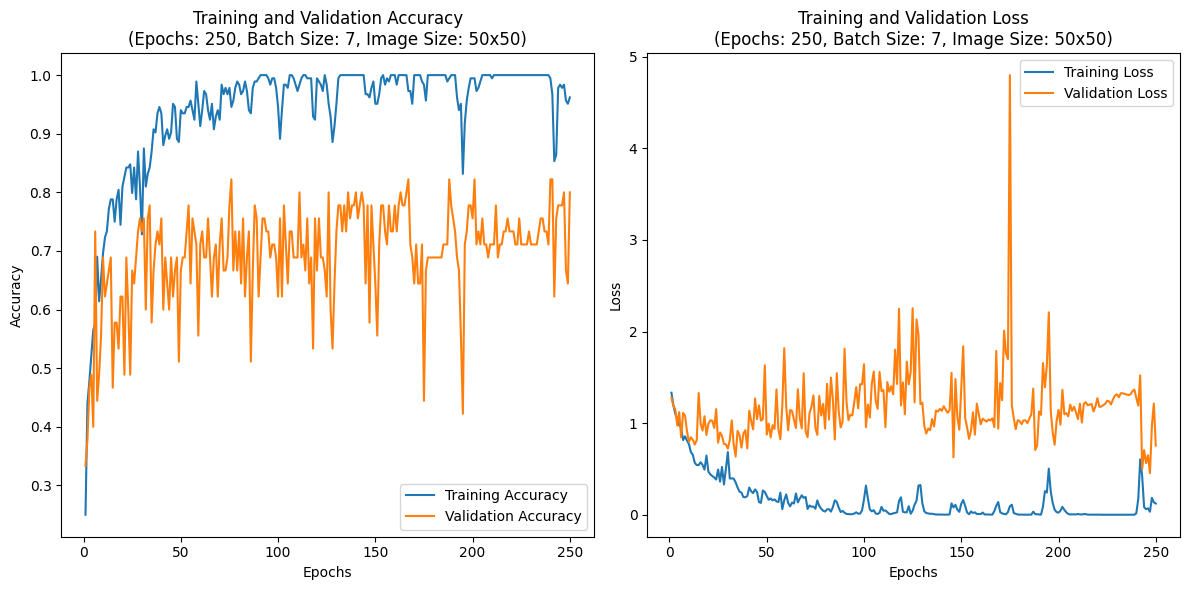

In [8]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Create line plots
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy\n(Epochs: {epoch_size}, Batch Size: {batch_size}, Image Size: {image_size[0]}x{image_size[1]})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title(f'Training and Validation Loss\n(Epochs: {epoch_size}, Batch Size: {batch_size}, Image Size: {image_size[0]}x{image_size[1]})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
val_data_cm = val_data.unbatch()
val_images = list(val_data_cm.map(lambda x, y: x))
val_labels = list(val_data_cm.map(lambda x, y: y))

In [10]:
# Save the model after the cross-validation
model.save('/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/models/Modelv2.tf')


INFO:tensorflow:Assets written to: /Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/models/Modelv2.tf/assets


INFO:tensorflow:Assets written to: /Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/models/Modelv2.tf/assets


In [11]:
!pip install gradio

In [12]:
pip install typing-extensions==4.5.0

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.0.3 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.3.0 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install typing-extensions --upgrade

  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import gradio as gr
import numpy as np

/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def predict_image(img):
    img_d=np.array(img).reshape(50,50)
    prediction=model.predict(img_d)[0]
    return {class_names[i]: float(prediction[i]) for i in range[4]}

In [16]:
image= gr.inputs.Image(shape=(50,50))
label= gr.outputs.Label(num_top_classes=4)

# Load your company logo using gr.Interface's 'logo' parameter
#company_logo = "/Users/ouzibigouziouzi/Downloads/LOGO.png"
description = "Upload an image and get the predicted class."
gr.Interface(fn=predict_image, inputs= image, outputs= label, live= True , title="SmartSense AgroTech", description= description ).launch(debug='True')

/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/.venv/lib/python3.9/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/.venv/lib/python3.9/site-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/.venv/lib/python3.9/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/ouzibigouziouzi/Desktop/Data Science/Hydroponics/.venv/lib/python3.9/site-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_clas

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
